In [22]:
require(xgboost)

In [23]:
data(agaricus.train, package='xgboost')
data(agaricus.test, package='xgboost')
train <- agaricus.train
test <- agaricus.test

In [24]:
str(train)

List of 2
 $ data :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:143286] 2 6 8 11 18 20 21 24 28 32 ...
  .. ..@ p       : int [1:127] 0 369 372 3306 5845 6489 6513 8380 8384 10991 ...
  .. ..@ Dim     : int [1:2] 6513 126
  .. ..@ Dimnames:List of 2
  .. .. ..$ : NULL
  .. .. ..$ : chr [1:126] "cap-shape=bell" "cap-shape=conical" "cap-shape=convex" "cap-shape=flat" ...
  .. ..@ x       : num [1:143286] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..@ factors : list()
 $ label: num [1:6513] 1 0 0 1 0 0 0 1 0 0 ...


In [25]:
dim(train$data)

[1] 6513  126

In [26]:
bstSparse <- xgboost(data = train$data, label = train$label, max.depth = 2,
                     eta = 1, nthread = 2, nround = 2, objective = "binary:logistic")

[1]	train-error:0.046522 
[2]	train-error:0.022263 


In [27]:
### using xgb matrix
dtrain <- xgb.DMatrix(data = train$data, label = train$label)
bstDMatrix <- xgboost(data = dtrain, max.depth = 2, eta = 1,
                      nthread = 2, nround = 2, objective = "binary:logistic")

[1]	train-error:0.046522 
[2]	train-error:0.022263 


In [28]:
# verbose = 1, print evaluation message ,  while with verbose 0, no message
bst <- xgboost(data = dtrain, max.depth = 2, eta = 1,
               nthread = 2, nround = 2, objective = "binary:logistic", verbose = 0)

In [29]:
# verbose = 2, also print information about tree
bst <- xgboost(data = dtrain, max.depth = 2, eta = 1,
               nthread = 2, nround = 2, objective = "binary:logistic", verbose = 2)

[02:30:51] amalgamation/../src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	train-error:0.046522 
[02:30:51] amalgamation/../src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2]	train-error:0.022263 


In [30]:
pred <- predict(bst, test$data)

# size of the prediction vector
print(length(pred))

[1] 1611


In [31]:
prediction <- as.numeric(pred > 0.5)
err <- mean(as.numeric(pred > 0.5) != test$label)
print(paste("test-error=", err))

[1] "test-error= 0.0217256362507759"


In [32]:
### Advanced features
dtrain <- xgb.DMatrix(data = train$data, label=train$label)
dtest <- xgb.DMatrix(data = test$data, label=test$label)

watchlist <- list(train=dtrain, test=dtest)

bst <- xgb.train(data=dtrain, max.depth=2, eta=1,
                 nthread = 2, nround=5, 
                 watchlist=watchlist, objective = "binary:logistic")

[1]	train-error:0.046522	test-error:0.042831 
[2]	train-error:0.022263	test-error:0.021726 
[3]	train-error:0.007063	test-error:0.006207 
[4]	train-error:0.015200	test-error:0.018001 
[5]	train-error:0.007063	test-error:0.006207 


In [33]:
bst <- xgb.train(data=dtrain, max.depth=2, eta=1, 
                 nthread = 2, nround=2, watchlist=watchlist,
                 eval.metric = "error", eval.metric = "logloss", objective = "binary:logistic")

[1]	train-error:0.046522	train-logloss:0.233376	test-error:0.042831	test-logloss:0.226686 
[2]	train-error:0.022263	train-logloss:0.136658	test-error:0.021726	test-logloss:0.137874 


In [34]:
#### linear boosting 
bst <- xgb.train(data=dtrain, booster = "gblinear", max.depth=2, 
                 nthread = 2, nround=2, watchlist=watchlist,
                 eval.metric = "error", eval.metric = "logloss", objective = "binary:logistic")

[1]	train-error:0.013204	train-logloss:0.180967	test-error:0.009932	test-logloss:0.181318 
[2]	train-error:0.003531	train-logloss:0.069245	test-error:0.001862	test-logloss:0.068043 


In [35]:
xgb.DMatrix.save(dtrain, "dtrain.buffer")

[1] TRUE

In [36]:
# to load it in, simply call xgb.DMatrix
dtrain2 <- xgb.DMatrix("dtrain.buffer")

[02:42:08] 6513x126 matrix with 143286 entries loaded from dtrain.buffer


In [37]:
bst <- xgb.train(data=dtrain2, max.depth=2, eta=1, 
                 nthread = 2, nround=2,
                 watchlist=watchlist, objective = "binary:logistic")

[1]	train-error:0.046522	test-error:0.042831 
[2]	train-error:0.022263	test-error:0.021726 


In [38]:
label = getinfo(dtest, "label")
pred <- predict(bst, dtest)
err <- as.numeric(sum(as.integer(pred > 0.5) != label))/length(label)
print(paste("test-error=", err))

[1] "test-error= 0.0217256362507759"


   Feature       Gain     Cover Frequency
1:      28 0.67615484 0.4978746       0.4
2:      55 0.17135352 0.1920543       0.2
3:      59 0.12317241 0.1638750       0.2
4:     108 0.02931922 0.1461960       0.2


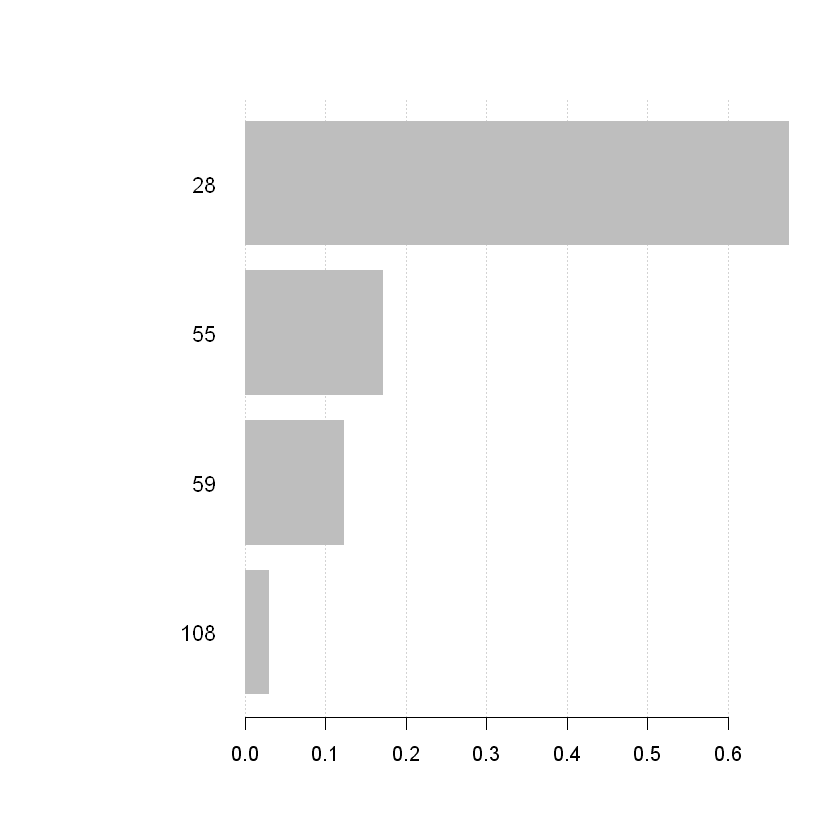

In [40]:
## feature importance
importance_matrix <- xgb.importance(model = bst)
print(importance_matrix)
xgb.plot.importance(importance_matrix = importance_matrix)

In [50]:
# save model to binary local file
xgb.save(bst, "xgboost.model")

[1] TRUE

In [64]:
# load binary model to R
bst2 <- xgb.load("xgboost.model")
pred2 <- predict(bst2, test$data)

# And now the test
print(paste("sum(abs(pred2-pred))=", sum(abs(pred2-pred))))

[1] "sum(abs(pred2-pred))= 0"
